In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Import libraries:

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

# Define the function to load images
def load_images_from_folder(folder):
    images = []
    labels = []
    
    for category in ["NORMAL", "PNEUMONIA"]:  # Adjust category names based on dataset
        path = os.path.join(folder, category)
        label = 0 if category == "NORMAL" else 1  # Assign labels
        
        for filename in os.listdir(path):
            img_path = os.path.join(path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read in grayscale
            img = cv2.resize(img, (224, 224))  # Resize to match CNN input size
            images.append(img)
            labels.append(label)

    return np.array(images), np.array(labels)

# Load dataset
X, y = load_images_from_folder('/kaggle/input/pediatric-pneumonia-chest-xray/Pediatric Chest X-ray Pneumonia/train')

# Reshape images to match CNN input format
X = X.reshape(X.shape[0], 224, 224, 1)

# Normalize the images
X = X.astype('float32') / 255.0

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print min & max to verify normalization
print("X_train min & max:", X_train.min(), X_train.max())
print("X_test min & max:", X_test.min(), X_test.max())


X_train min & max: 0.0 1.0
X_test min & max: 0.0 1.0


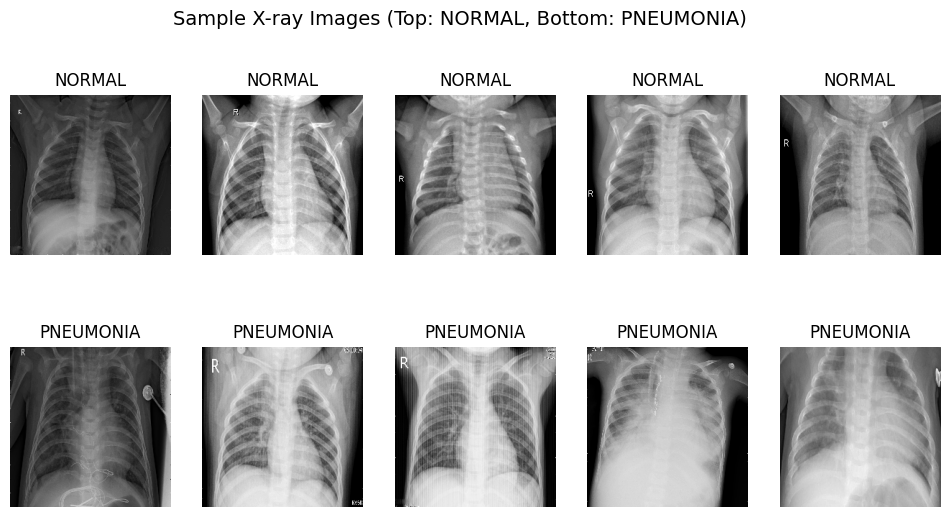

In [3]:
# Visualizing some images
# Function to plot sample images from both classes
def plot_sample_images(X, y, class_names=['NORMAL', 'PNEUMONIA']):
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    fig.suptitle("Sample X-ray Images (Top: NORMAL, Bottom: PNEUMONIA)", fontsize=14)

    # Find indices of NORMAL and PNEUMONIA images
    normal_indices = np.where(y == 0)[0]
    pneumonia_indices = np.where(y == 1)[0]

    # Plot NORMAL images (first row)
    for i, ax in enumerate(axes[0]):
        idx = normal_indices[i] if i < len(normal_indices) else normal_indices[0]
        ax.imshow(X[idx].squeeze(), cmap='gray')
        ax.set_title("NORMAL")
        ax.axis("off")

    # Plot PNEUMONIA images (second row)
    for i, ax in enumerate(axes[1]):
        idx = pneumonia_indices[i] if i < len(pneumonia_indices) else pneumonia_indices[0]
        ax.imshow(X[idx].squeeze(), cmap='gray')
        ax.set_title("PNEUMONIA")
        ax.axis("off")

    plt.show()

# Call the function to plot sample images
plot_sample_images(X, y)


In [4]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


X_train shape: (4185, 224, 224, 1)
X_test shape: (1047, 224, 224, 1)


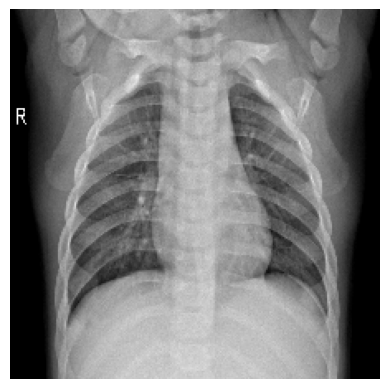

In [5]:
import matplotlib.pyplot as plt

sample_image = X_train[0]  # Take first image

if sample_image.ndim == 3 and sample_image.shape[-1] == 1:
    sample_image = sample_image.squeeze()  # Convert (224, 224, 1) → (224, 224)

plt.imshow(sample_image, cmap='gray')
plt.axis('off')
plt.show()


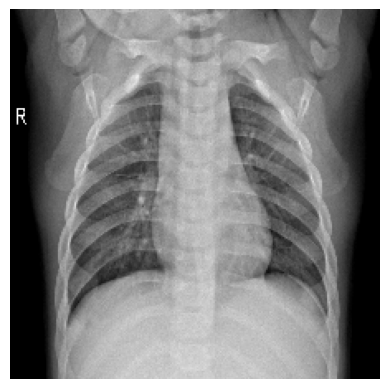

In [6]:
import matplotlib.pyplot as plt

plt.imshow(X_train[0].squeeze(), cmap='gray')  # Remove extra channel
plt.axis('off')
plt.show()


In [7]:
# Split data into different train-test-validation splits
X_train_90, X_test, y_train_90, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train_80, X_val_20, y_train_80, y_val_20 = train_test_split(X_train_90, y_train_90, test_size=0.22, random_state=42)
X_train_70, X_val_30, y_train_70, y_val_30 = train_test_split(X_train_90, y_train_90, test_size=0.33, random_state=42)

In [8]:
# Ensure data is in correct shape (batch, height, width, channels)
X_train_90 = X_train_90.reshape(-1, 224, 224, 1)
X_test = X_test.reshape(-1, 224, 224, 1)

# Updated Data Augmentation with more variations
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.3,         # More aggressive shearing
    zoom_range=0.3,          # Increase zoom variation
    horizontal_flip=True,
    vertical_flip=True,       # Allow vertical flips
    rotation_range=30,        # Increase rotation range
    width_shift_range=0.15,   # More horizontal shifts
    height_shift_range=0.15,  # More vertical shifts
    brightness_range=[0.7, 1.3], # Vary brightness
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)  # Normalize validation data

def create_data_generator(X, y, datagen, batch_size=32):
    return datagen.flow(X, y, batch_size=batch_size, shuffle=True)

# Create train & validation generators
train_generator_90 = create_data_generator(X_train_90, y_train_90, train_datagen)
val_generator_90 = create_data_generator(X_test, y_test, val_datagen)


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Define model function
def build_cnn_model(input_shape=(224, 224, 1)):
    model = Sequential()

    model.add(Input(shape=input_shape))  # Input layer

    # Conv Block 1
    model.add(Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(negative_slope=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Conv Block 2
    model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(negative_slope=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Conv Block 3
    model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(negative_slope=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Conv Block 4
    model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(negative_slope=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(512, kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(negative_slope=0.1))
    model.add(Dropout(0.5))  # Dropout to prevent overfitting

    model.add(Dense(256, kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(negative_slope=0.1))
    model.add(Dropout(0.5))

    model.add(Dense(1, activation='sigmoid'))  # Binary Classification

    return model

# Compile the model
model = build_cnn_model()
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')

# Model Summary
model.summary()




Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      25,690,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │              

 Total params: 26,215,041 (100.00 MB)

 Trainable params: 26,212,545 (99.99 MB)

 Non-trainable params: 2,496 (9.75 KB)

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

def train_and_evaluate(X_train, y_train, X_val, y_val, split_name):
    model = build_cnn_model()  # Ensure function is defined

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Define Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
    checkpoint = ModelCheckpoint(f"best_model_{split_name}.keras", save_best_only=True, monitor='val_loss', mode='min')

    # Reshape input if needed (add channel dimension)
    if len(X_train.shape) == 3:
        X_train = X_train.reshape(-1, 224, 224, 1)
        X_val = X_val.reshape(-1, 224, 224, 1)

    # Train the model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                        epochs=20, batch_size=32, 
                        callbacks=[early_stopping, reduce_lr, checkpoint])

    # Evaluate on validation data
    test_loss, test_acc = model.evaluate(X_val, y_val)

    # Get predictions
    y_pred = (model.predict(X_val) > 0.5).astype(int)

    print(f"{split_name} Test Accuracy: {test_acc:.4f}")
    return model, history, test_acc, y_val, y_pred

# Run for different splits
model_90, history_90, acc_90, y_test_actual, y_test_pred = train_and_evaluate(X_train_90, y_train_90, X_test, y_test, "90:10")
model_80, history_80, acc_80, y_val_20_actual, y_val_20_pred = train_and_evaluate(X_train_80, y_train_80, X_val_20, y_val_20, "80:20")
model_70, history_70, acc_70, y_val_30_actual, y_val_30_pred = train_and_evaluate(X_train_70, y_train_70, X_val_30, y_val_30, "70:30")


Epoch 1/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 39s 145ms/step - accuracy: 0.9082 - loss: 2.1045 - val_accuracy: 0.7252 - val_loss: 3.4337 - learning_rate: 0.0010
Epoch 2/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.9574 - loss: 1.2167 - val_accuracy: 0.7252 - val_loss: 3.5957 - learning_rate: 0.0010
Epoch 3/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/step - accuracy: 0.9636 - loss: 0.8211 - val_accuracy: 0.7252 - val_loss: 2.5816 - learning_rate: 0.0010
Epoch 4/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/step - accuracy: 0.9608 - loss: 0.7586 - val_accuracy: 0.7290 - val_loss: 1.7754 - learning_rate: 0.0010
Epoch 5/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 12s 81ms/step - accuracy: 0.9655 - loss: 0.6172 - val_accuracy: 0.7634 - val_loss: 1.1259 - learning_rate: 0.0010
Epoch 6/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 12s 81ms/step - accuracy: 0.9684 - loss: 0.5487 - val_accuracy: 0.8779 - val_loss: 0.6828 - learning_rate: 0.0010
Epoch 7/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 12s 82ms/step - accuracy: 0.9687 - 

In [11]:

results = {"90:10": acc_90 * 100, "80:20": acc_80 * 100, "70:30": acc_70 * 100}
for split, acc in results.items():
    print(f"✅ {split} Split - Test Accuracy: {acc:.2f}%")

✅ 90:10 Split - Test Accuracy: 95.42%
✅ 80:20 Split - Test Accuracy: 97.39%
✅ 70:30 Split - Test Accuracy: 98.33%


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


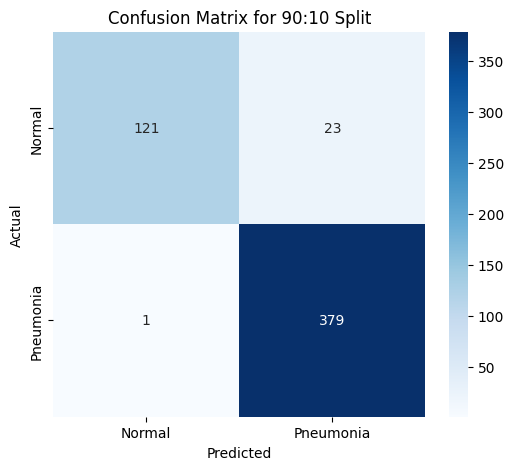

Classification Report for 90:10 Split:
              precision    recall  f1-score   support

      Normal       0.99      0.84      0.91       144
   Pneumonia       0.94      1.00      0.97       380

    accuracy                           0.95       524
   macro avg       0.97      0.92      0.94       524
weighted avg       0.96      0.95      0.95       524

90:10 Accuracy: 0.9542
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


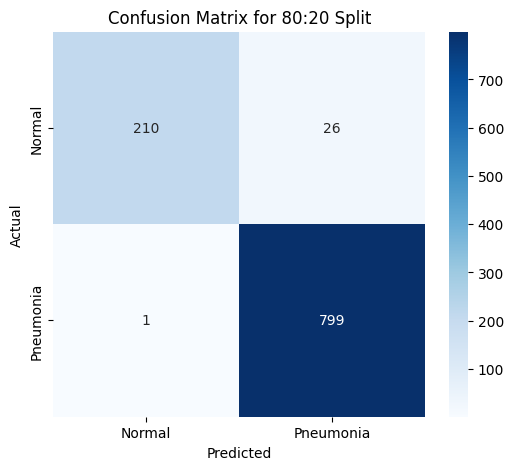

Classification Report for 80:20 Split:
              precision    recall  f1-score   support

      Normal       1.00      0.89      0.94       236
   Pneumonia       0.97      1.00      0.98       800

    accuracy                           0.97      1036
   macro avg       0.98      0.94      0.96      1036
weighted avg       0.97      0.97      0.97      1036

80:20 Accuracy: 0.9739
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


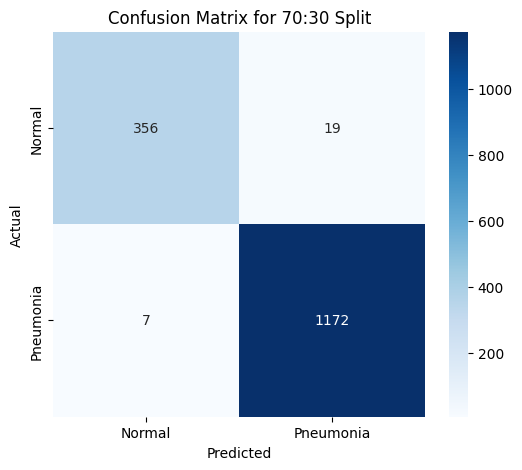

Classification Report for 70:30 Split:
              precision    recall  f1-score   support

      Normal       0.98      0.95      0.96       375
   Pneumonia       0.98      0.99      0.99      1179

    accuracy                           0.98      1554
   macro avg       0.98      0.97      0.98      1554
weighted avg       0.98      0.98      0.98      1554

70:30 Accuracy: 0.9833


In [12]:

# Evaluate models (including confusion matrix)
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, X_val, y_val, split_name):
    # Get predictions
    y_pred = (model.predict(X_val) > 0.5).astype(int)
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
    plt.title(f'Confusion Matrix for {split_name} Split')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Print classification report
    print(f"Classification Report for {split_name} Split:")
    print(classification_report(y_val, y_pred, target_names=['Normal', 'Pneumonia']))
    
    # Calculate accuracy
    accuracy = (cm[0, 0] + cm[1, 1]) / cm.sum()
    print(f"{split_name} Accuracy: {accuracy:.4f}")
    return accuracy, cm

# Run for different splits
acc_90, cm_90 = evaluate_model(model_90, X_test, y_test, "90:10")
acc_80, cm_80 = evaluate_model(model_80, X_val_20, y_val_20, "80:20")
acc_70, cm_70 = evaluate_model(model_70, X_val_30, y_val_30, "70:30")


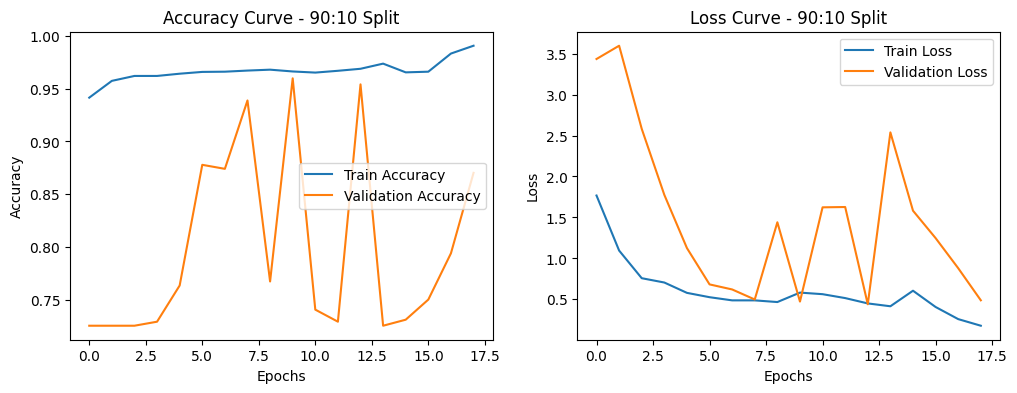

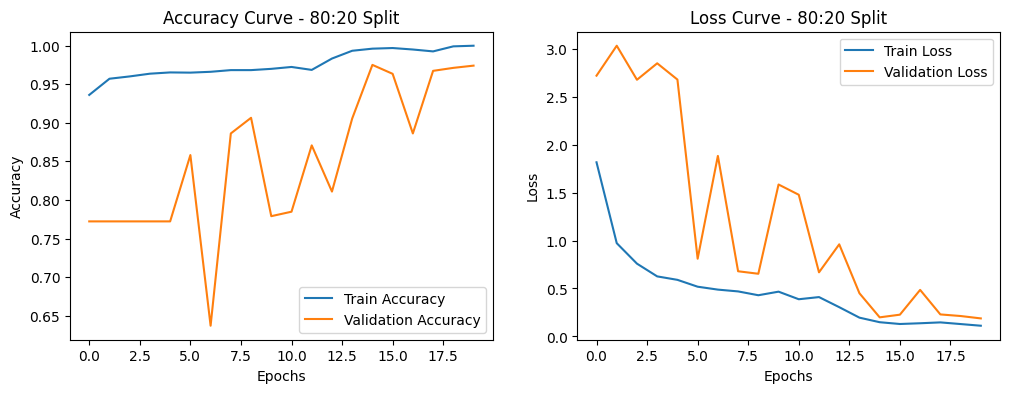

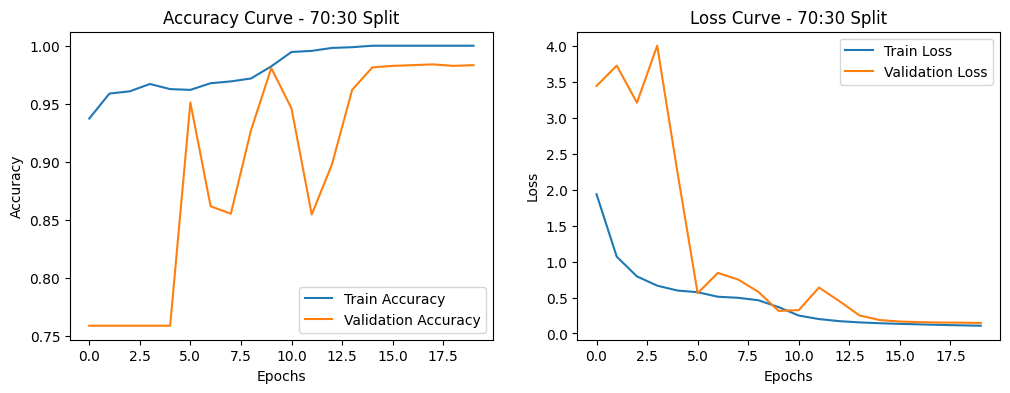

In [13]:
import matplotlib.pyplot as plt

# Function to plot accuracy & loss for a given history
def plot_training_history(history, split_name):
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy Curve - {split_name} Split')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Loss Curve - {split_name} Split')
    plt.legend()

    plt.show()

# Plot training history for all splits
plot_training_history(history_90, "90:10")
plot_training_history(history_80, "80:20")
plot_training_history(history_70, "70:30")


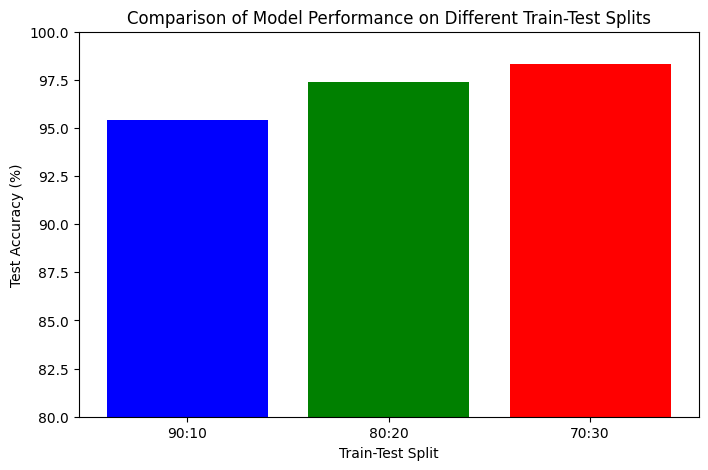

In [14]:
# Compare accuracy across different splits
splits = ['90:10', '80:20', '70:30']
accuracies = [acc_90 * 100, acc_80 * 100, acc_70 * 100]

plt.figure(figsize=(8, 5))
plt.bar(splits, accuracies, color=['blue', 'green', 'red'])
plt.xlabel("Train-Test Split")
plt.ylabel("Test Accuracy (%)")
plt.title("Comparison of Model Performance on Different Train-Test Splits")
plt.ylim([80, 100])
plt.show()


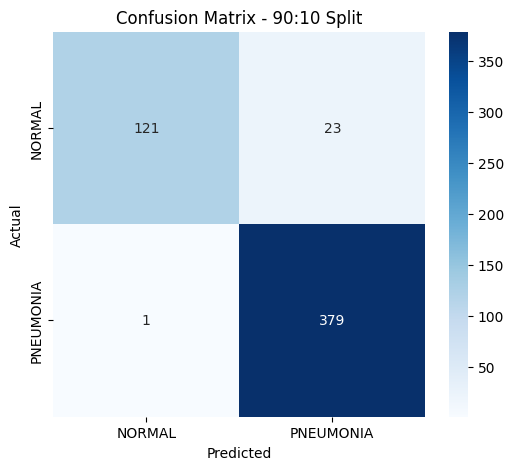

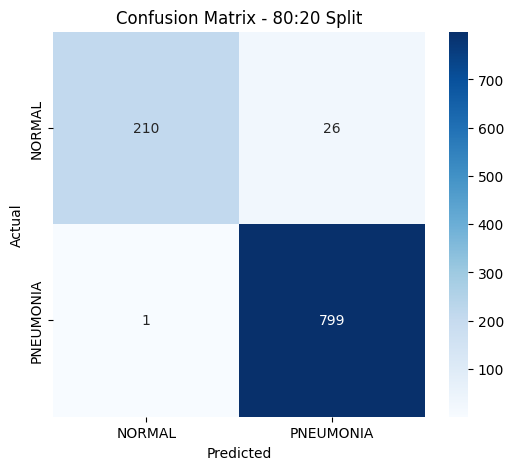

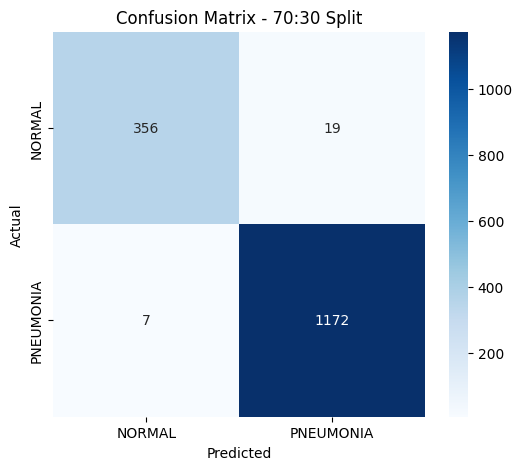

In [15]:

for actual, pred, split in zip([y_test_actual, y_val_20_actual, y_val_30_actual], [y_test_pred, y_val_20_pred, y_val_30_pred], ["90:10", "80:20", "70:30"]):
    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion_matrix(actual, pred), annot=True, fmt='d', cmap='Blues', xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {split} Split')
    plt.show()

In [16]:

results = {
    "90:10": acc_90 * 100,
    "80:20": acc_80 * 100,
    "70:30": acc_70 * 100
}

# Print results
for split, acc in results.items():
    print(f"✅ {split} Split - Test Accuracy: {acc:.2f}%")


✅ 90:10 Split - Test Accuracy: 95.42%
✅ 80:20 Split - Test Accuracy: 97.39%
✅ 70:30 Split - Test Accuracy: 98.33%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


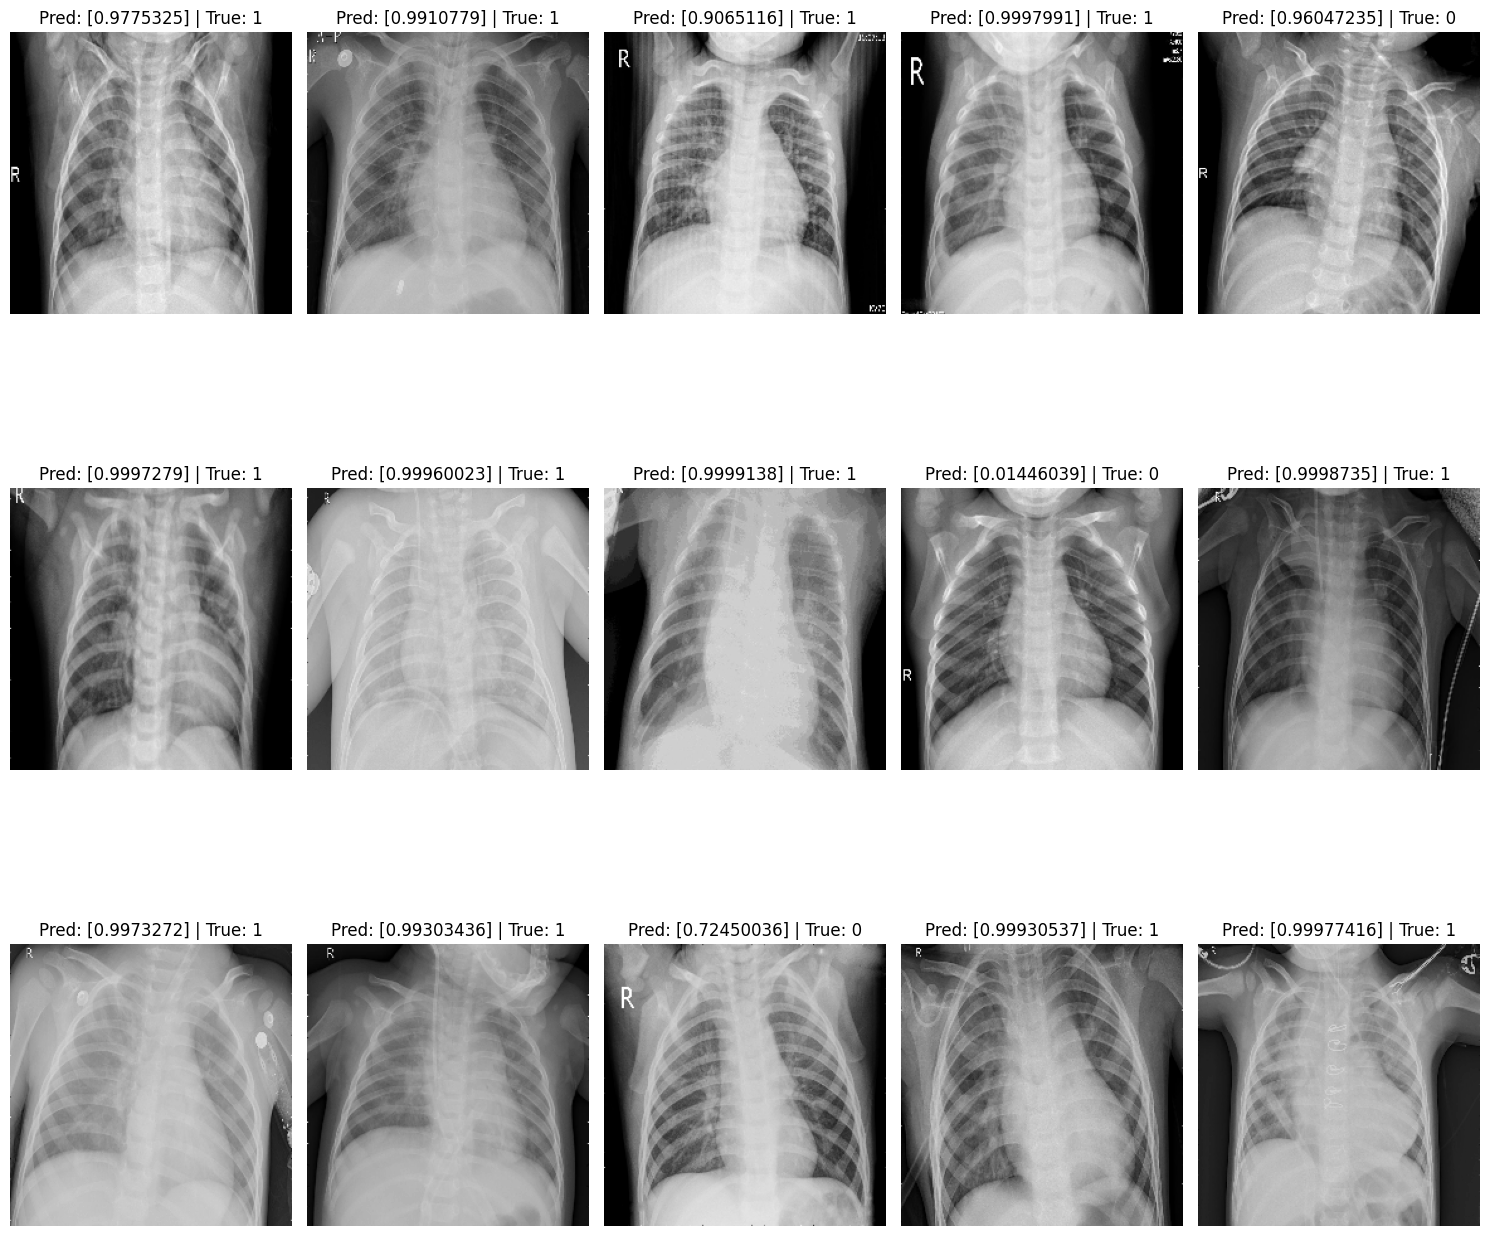

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Number of images to display
num_images = 15

# Select random indices from the test set
indices = np.random.choice(len(X_test), num_images, replace=False)

# Create a figure to display images
plt.figure(figsize=(15, 15))

for i, idx in enumerate(indices):
    plt.subplot(3, 5, i + 1)
    plt.imshow(X_test[idx], cmap='gray')  # Assuming images are in grayscale
    plt.title(f"Pred: {model_90.predict(X_test[idx:idx+1])[0]} | True: {y_test[idx]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [20]:
# Save models
model_90.save('pneumonia_CNNmodel_90_10.h5')
model_80.save('pneumonia_CNNmodel_80_20.h5')
model_70.save('pneumonia_CNNmodel_70_30.h5')

# Save results
np.save('test_results.npy', {"90:10": acc_90 * 100, "80:20": acc_80 * 100, "70:30": acc_70 * 100})